In [ ]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, Future
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Assignment 1
In this assignment you will be creating tools for learning and testing language models.
The corpora that you will be working with are lists of tweets in 8 different languages that use the Latin script. The data is provided either formatted as CSV or as JSON, for your convenience. The end goal is to write a set of tools that can detect the language of a given tweet.

Do make sure all results are uploaded to CSVs (as well as printed to console) for your assignment to be fully graded.

*As a preparation for this task, download the data files from the course git repository.

The relevant files are under **lm-languages-data-new**:


*   en.csv (or the equivalent JSON file)
*   es.csv (or the equivalent JSON file)
*   fr.csv (or the equivalent JSON file)
*   in.csv (or the equivalent JSON file)
*   it.csv (or the equivalent JSON file)
*   nl.csv (or the equivalent JSON file)
*   pt.csv (or the equivalent JSON file)
*   tl.csv (or the equivalent JSON file)
*   test.csv (or the equivalent JSON file)







---



**Important note: please use only the files under lm-languages-data-new and NOT under lm-languages-data**


---



## Parameters

In [ ]:
STUDENT_1_ID = '1'
STUDENT_2_ID = '2'
START_TOKEN = '<START>'
END_TOKEN = '<END>'

relevant_files = ['en', 'es', 'fr', 'in', 'it', 'nl', 'pt', 'tl', 'test']
relevant_languages = relevant_files[:-1]

**Part 1**

Write a function *preprocess* that iterates over all the data files and creates a single vocabulary, containing all the tokens in the data. **Our token definition is a single UTF-8 encoded character**. So, the vocabulary list is a simple Python list of all the characters that you see at least once in the data.

In [ ]:
def get_tokens(series: pd.Series, n, unique=False):
    arr = series.apply(list).apply(lambda x: (n-1)*[START_TOKEN] + x + [END_TOKEN]).values
    tokens = [item for sublist in arr for item in sublist]
    if unique:
        tokens = set(tokens)

    return tokens

In [ ]:
def get_language_tokens(lang: str, n, unique=False):
    series = pd.read_csv(f'./nlp-course/lm-languages-data-new/{lang}.csv')['tweet_text']
    return get_tokens(series, n, unique)

In [ ]:
def preprocess(relevant_languages: list[str], extra_tokens = []) -> list[str]:
  vocabulary = {*extra_tokens}

  for lang in relevant_languages:
    lang_tokens = get_language_tokens(lang, n=2, unique=True)
    vocabulary = vocabulary.union(lang_tokens)

  return list(vocabulary)

In [ ]:
vocabulary = preprocess(relevant_files)

**Part 2**

Write a function lm that generates a language model from a textual corpus. The function should return a dictionary (representing a model) where the keys are all the relevant n-1 sequences, and the values are dictionaries with the n_th tokens and their corresponding probabilities to occur. For example, for a trigram model (tokens are characters), it should look something like:

{
  "ab":{"c":0.5, "b":0.25, "d":0.25},
  "ca":{"a":0.2, "b":0.7, "d":0.1}
}

which means for example that after the sequence "ab", there is a 0.5 chance that "c" will appear, 0.25 for "b" to appear and 0.25 for "d" to appear.

Note - You should think how to add the add_one smoothing information to the dictionary and implement it.

In [ ]:
def lm(n, vocabulary, data_file_path, add_one=False):
  # n - the n-gram to use (e.g., 1 - unigram, 2 - bigram, etc.)
  # vocabulary - the vocabulary list (which you should use for calculating add_one smoothing)
  # data_file_path - the data_file from which we record probabilities for our model
  # add_one - True/False (use add_one smoothing or not)
  counts = defaultdict(lambda: defaultdict(float))
  bias = len(vocabulary) if add_one else 0

  for i in range(len(data_file_path) - n + 1):
    n_gram = data_file_path[i:i+n]
    key, value = ''.join(n_gram[:-1]), n_gram[-1]
    counts[key][value] += 1

  lm = {k: defaultdict(lambda:1/bias if add_one else 0, {v: (counts[k][v] + add_one) / (sum(counts[k].values()) + bias) for v in counts[k]}) for k in counts}
  robust_lm = defaultdict(lambda: defaultdict(lambda: 1/bias if add_one else 0), lm)

  return robust_lm

**Part 3**

Write a function *eval* that returns the perplexity of a model (dictionary) running over a given data file.

In [ ]:
def eval(data_file, model, n):
  # n - the n-gram that you used to build your model (must be the same number)
  # model - the dictionary (model) to use for calculating perplexity
  # data_file - the tweets file that you wish to claculate a perplexity score for
  entropies = []
  p = []
  for i in range(len(data_file) - n + 1):
    n_gram = data_file[i:i+n]
    key, value = ''.join(n_gram[:-1]), n_gram[-1]
    prob = model[key][value]
    p.append(-np.log2(prob) if prob else 0)

    if value == END_TOKEN:
      entropy = np.mean(p)
      entropies.append(entropy)
      p = []

  return 2 ** np.mean(entropies)

**Part 4**

Write a function *match* that creates a model for every relevant language, using a specific value of *n* and *add_one*. Then, calculate the perplexity of all possible pairs (e.g., en model applied on the data files en ,es, fr, in, it, nl, pt, tl; es model applied on the data files en, es...). This function should return a pandas DataFrame with columns [en ,es, fr, in, it, nl, pt, tl] and every row should be labeled with one of the languages. Then, the values are the relevant perplexity values.

Save the dataframe to a CSV with the name format: {student_id_1}\_...\_{student_id_n}\_part4.csv

In [ ]:
def generate_models(n: int, vocabulary: list[str], relevant_languages: list[str], add_one: bool):
    corpuses = {}
    models = []
    for lang in relevant_languages:
        corpuses[lang] = get_language_tokens(lang, n)
        models.append(lm(n, vocabulary, corpuses[lang], add_one))

    return models, corpuses

In [ ]:
def generate_models_async(n: int, vocabulary: list[str], relevant_languages: list[str], add_one: bool):
    corpuses = {}
    threads: list[Future] = []
    with ThreadPoolExecutor(max_workers=len(relevant_languages)) as executor:
        for lang in relevant_languages:
            corpuses[lang] = get_language_tokens(lang, n)
            threads.append(executor.submit(lm, n, vocabulary, corpuses[lang], add_one))

    models = {lang: t.result() for lang, t in zip(relevant_languages, threads)}

    return models, corpuses

In [ ]:
models, corpuses = generate_models_async(4, vocabulary, relevant_languages, True)

In [ ]:
def match(n: int, relevant_languages: list[str], add_one: bool):
  # n - the n-gram to use for creating n-gram models
  # add_one - use add_one smoothing or not
  vocabulary = preprocess(relevant_languages)
  models, corpuses = generate_models_async(n, vocabulary, relevant_languages, add_one)
  perplexities = {}

  for lang in relevant_languages:
    perplexities[lang] = [eval(corpuses[l], models[lang], n) for l in relevant_languages]

  df =  pd.DataFrame(perplexities, index=perplexities)
  df.index.name = 'Language'
  df.columns.name = 'Model'

  return models, df

In [ ]:
_ , perplexities = match(4, relevant_languages, add_one=True)
perplexities.to_csv(f'{STUDENT_1_ID}_{STUDENT_2_ID}_part4.csv')
perplexities

Model,en,es,fr,in,it,nl,pt,tl
Language,,,,,,,,
en,58.018054,242.180878,199.138775,217.242106,232.484672,181.656340,272.277508,174.452369
es,228.812066,53.207758,173.568787,264.964843,153.582469,255.963385,142.280011,236.732772
fr,200.670278,195.563501,52.655016,280.141796,208.959305,217.268372,240.003286,275.439699
in,311.139528,327.374610,331.377700,76.843354,330.972234,308.663796,370.073240,221.972803
it,234.198236,166.710250,205.792551,261.808904,56.180412,272.011156,202.109421,236.445287
nl,214.136187,277.736234,241.155319,266.342147,289.849593,64.275272,335.965646,277.796760
pt,255.161731,140.465265,211.384699,280.558704,171.305539,290.642918,55.090299,257.392815
tl,244.499835,287.330321,299.065865,180.269983,251.936140,259.276860,290.010813,65.569562


Text(0.5, 1.0, 'Negative Softmax Perplexities')

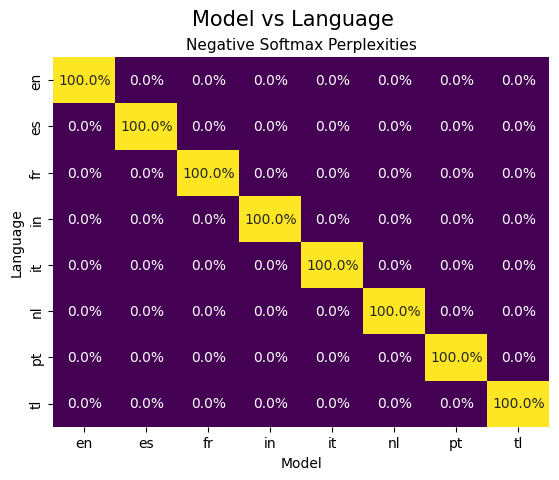

In [ ]:
sns.heatmap(np.e**-perplexities / (np.e**-perplexities).sum(axis=0), cmap='viridis', annot=True, cbar=False, fmt='.1%')
plt.suptitle('Model vs Language', size=15)
plt.title('Negative Softmax Perplexities', size=11)

**Part 5**

Run match with *n* values 1-4, once with add_one and once without, and print the 8 tables to this notebook, one after another.

Load each result to a dataframe and save to a CSV with the name format:

for cases with add_one: {student_id_1}\_...\_{student_id_n}\_n1\_part5.csv

For cases without add_one:
{student_id_1}\_...\_{student_id_n}\_n1\_wo\_addone\_part5.csv

Follow the same format for n2,n3, and n4


In [ ]:
def run_match(max_n: int, relevant_languages: list[str], export_files=False, verbose=False) -> dict[str, pd.DataFrame]:
  n_perplexities = defaultdict(dict[bool, pd.DataFrame])
  models = {}
  for n in np.arange(1, max_n+1):
    for add_one in [False, True]:
      models[(n,add_one)], n_perplexities[n][add_one] = match(n, relevant_languages, add_one)

      if export_files:
        n_perplexities[n][add_one].to_csv(f'{STUDENT_1_ID}_{STUDENT_2_ID}_n{n}{"_part5" if add_one else "_wo_add_done_part5"}.csv')

    if verbose:
      print(f'done with n = {n}, add_one: {add_one}')

  return models, n_perplexities

In [ ]:
models, n_perplexities = run_match(4, relevant_languages, export_files=True, verbose=True)

done with n = 1, add_one: True
done with n = 2, add_one: True
done with n = 3, add_one: True
done with n = 4, add_one: True


In [ ]:
n_perplexities[4][True]

Model,en,es,fr,in,it,nl,pt,tl
Language,,,,,,,,
en,58.018054,242.180878,199.138775,217.242106,232.484672,181.656340,272.277508,174.452369
es,228.812066,53.207758,173.568787,264.964843,153.582469,255.963385,142.280011,236.732772
fr,200.670278,195.563501,52.655016,280.141796,208.959305,217.268372,240.003286,275.439699
in,311.139528,327.374610,331.377700,76.843354,330.972234,308.663796,370.073240,221.972803
it,234.198236,166.710250,205.792551,261.808904,56.180412,272.011156,202.109421,236.445287
nl,214.136187,277.736234,241.155319,266.342147,289.849593,64.275272,335.965646,277.796760
pt,255.161731,140.465265,211.384699,280.558704,171.305539,290.642918,55.090299,257.392815
tl,244.499835,287.330321,299.065865,180.269983,251.936140,259.276860,290.010813,65.569562


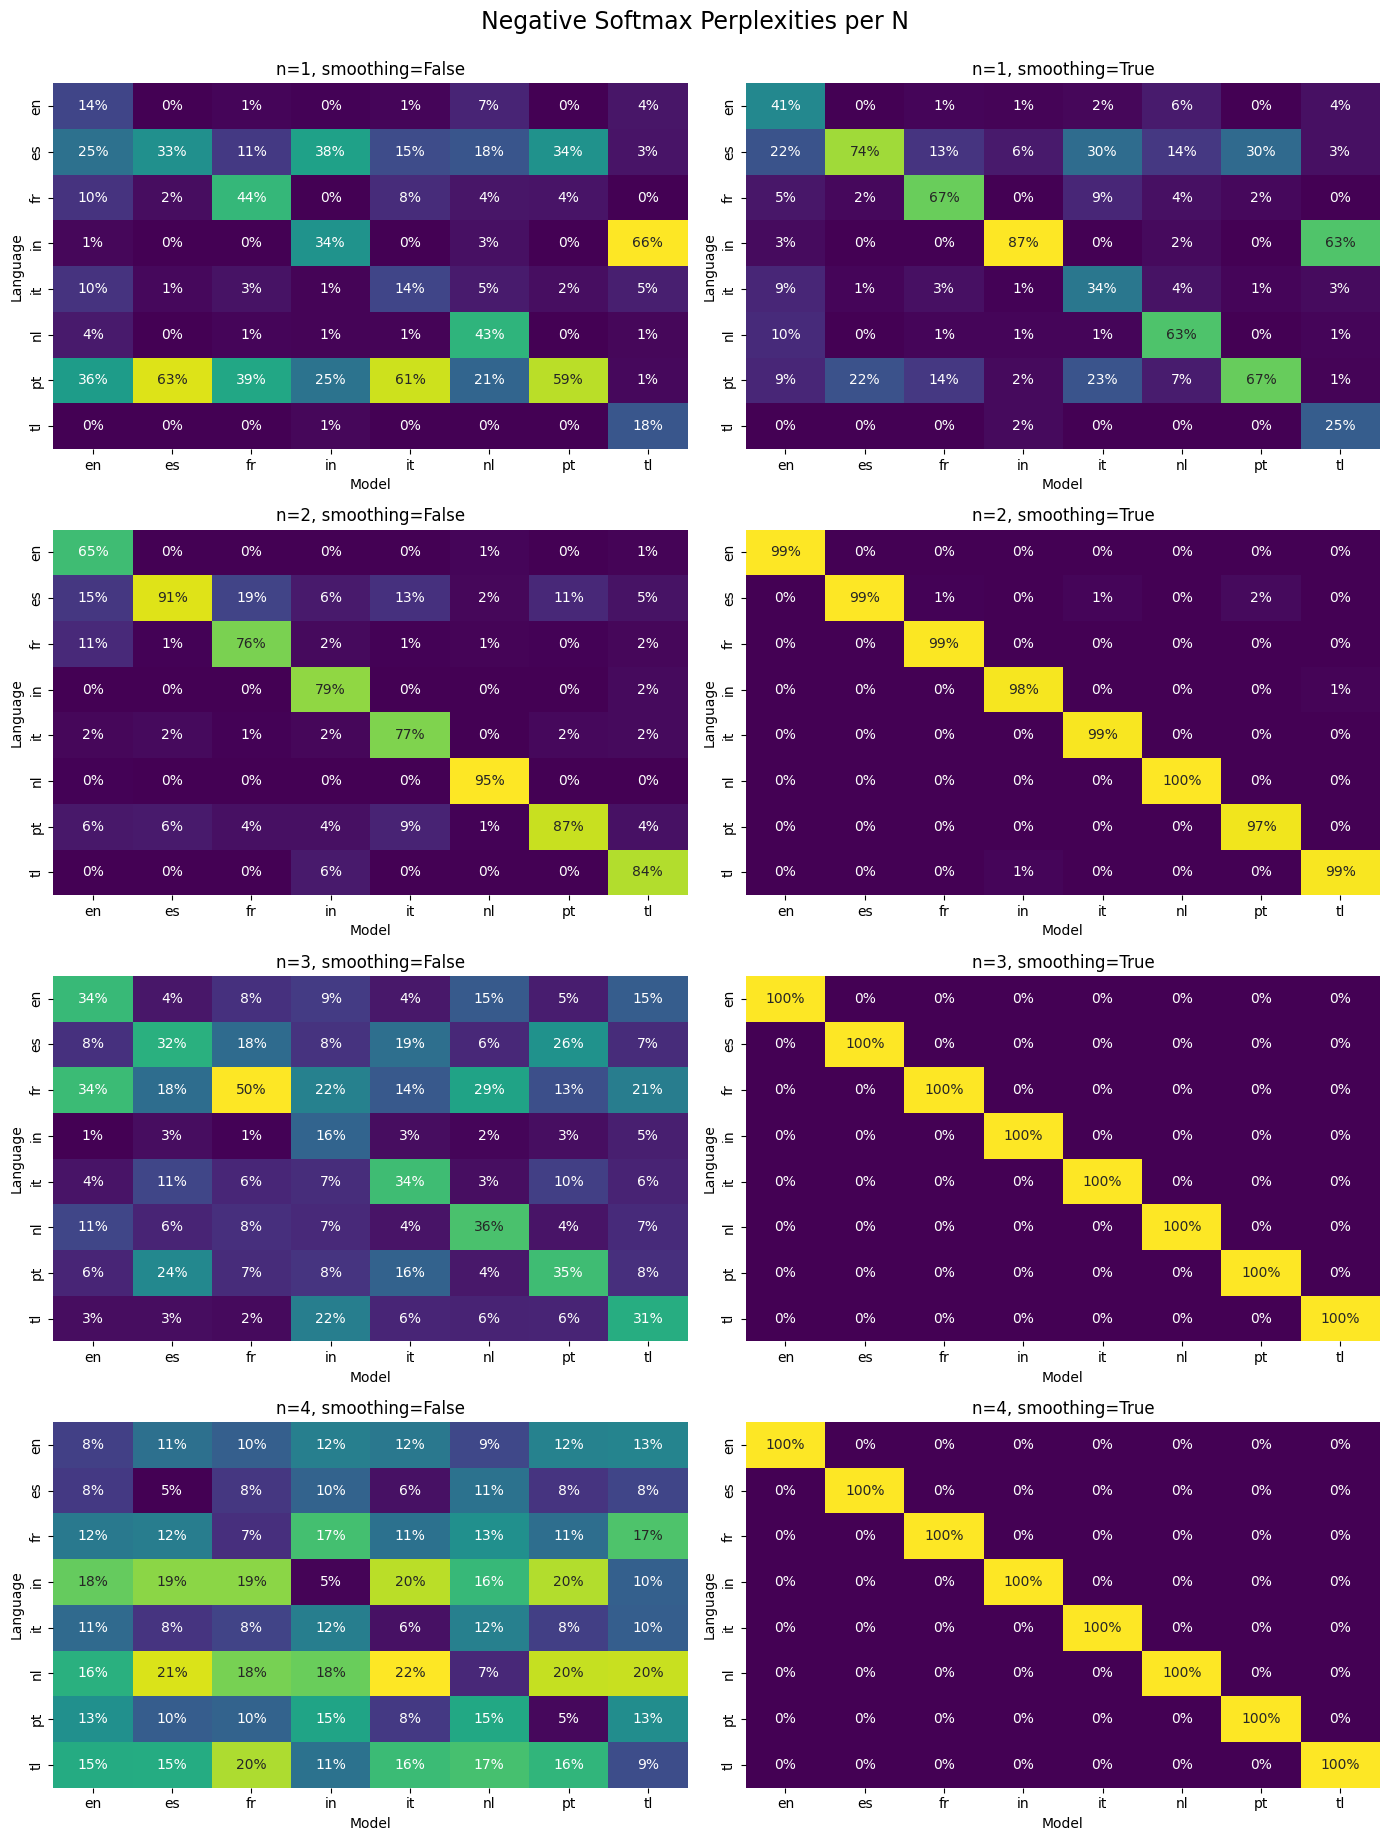

In [ ]:
fig, axes = plt.subplots(len(n_perplexities), 2, figsize=(14,18))

for i, n in enumerate(n_perplexities):
    for add_one in [True, False]:
        perplexities = n_perplexities[n][add_one]
        ax = axes[i,1 if add_one else 0]
        neg_softmax_perplexities = np.e**-perplexities / (np.e**-perplexities).sum(axis=0)
        sns.heatmap(neg_softmax_perplexities, cmap='viridis', annot=True, cbar=False, fmt='.0%', ax=ax)
        ax.set_title(f'n={n}, smoothing={add_one}')
plt.tight_layout()
plt.suptitle('Negative Softmax Perplexities per N', y=1.02, size=17);

**Part 6**

Each line in the file test.csv contains a sentence and the language it belongs to. Write a function that uses your language models to classify the correct language of each sentence.

Important note regarding the grading of this section: this is an open question, where a different solution will yield different accuracy scores. any solution that is not trivial (e.g. returning 'en' in all cases) will be accepted. We do reserve the right to give bonus points to exceptionally good/creative solutions.

In [ ]:
def classify():
  df = pd.read_csv('./nlp-course/lm-languages-data-new/test.csv')
  for n, add_one in models.keys():
    proccessed_tweet_series = df['tweet_text'].apply(list).apply(lambda x: (n-1)*[START_TOKEN] + x + [END_TOKEN])
    perplexities_df = pd.DataFrame({lang: proccessed_tweet_series.apply(eval, args=(models[(n, add_one)][lang], n)) for lang in relevant_languages})
    df[f'add_one: {add_one}-{n}-gram'] = perplexities_df.idxmin(1)

  return df

In [ ]:
clasification_result = classify()


In [ ]:
def calc_score(func, result: pd.DataFrame, params = {"average":'micro'}):
  scores_dict = {f'add_one:{add_one} - {n}_gram': round(func(clasification_result['label'], clasification_result[f'add_one: {add_one}-{n}-gram'], **params),3) for n ,add_one in models.keys()}
  scores_dict = dict(sorted(scores_dict.items()))
  return pd.DataFrame({"model_name": scores_dict.keys(), func.__name__: scores_dict.values()})

In [ ]:
calc_score(accuracy_score, clasification_result, params={})

,model_name,accuracy_score
0,add_one:False - 1_gram,0.521
1,add_one:False - 2_gram,0.787
2,add_one:False - 3_gram,0.714
3,add_one:False - 4_gram,0.196
4,add_one:True - 1_gram,0.635
5,add_one:True - 2_gram,0.874
6,add_one:True - 3_gram,0.929
7,add_one:True - 4_gram,0.932


**Part 7**

Calculate the F1 score of your output from part 6. (hint: you can use https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

Load the results to a CSV (using a DataFrame), where the row indicates the F1 results, and the columns indicate the model used. Name it {student_id_1}\_...\_{student_id_n}\_part7.csv

In [ ]:
def calc_f1(result: pd.DataFrame):
  return calc_score(f1_score, result)


In [ ]:
f1_score_df = calc_f1(clasification_result)
f1_score_df.to_csv(f'{STUDENT_1_ID}_{STUDENT_2_ID}_part7.csv')
f1_score_df

,model_name,f1_score
0,add_one:False - 1_gram,0.521
1,add_one:False - 2_gram,0.787
2,add_one:False - 3_gram,0.714
3,add_one:False - 4_gram,0.196
4,add_one:True - 1_gram,0.635
5,add_one:True - 2_gram,0.874
6,add_one:True - 3_gram,0.929
7,add_one:True - 4_gram,0.932


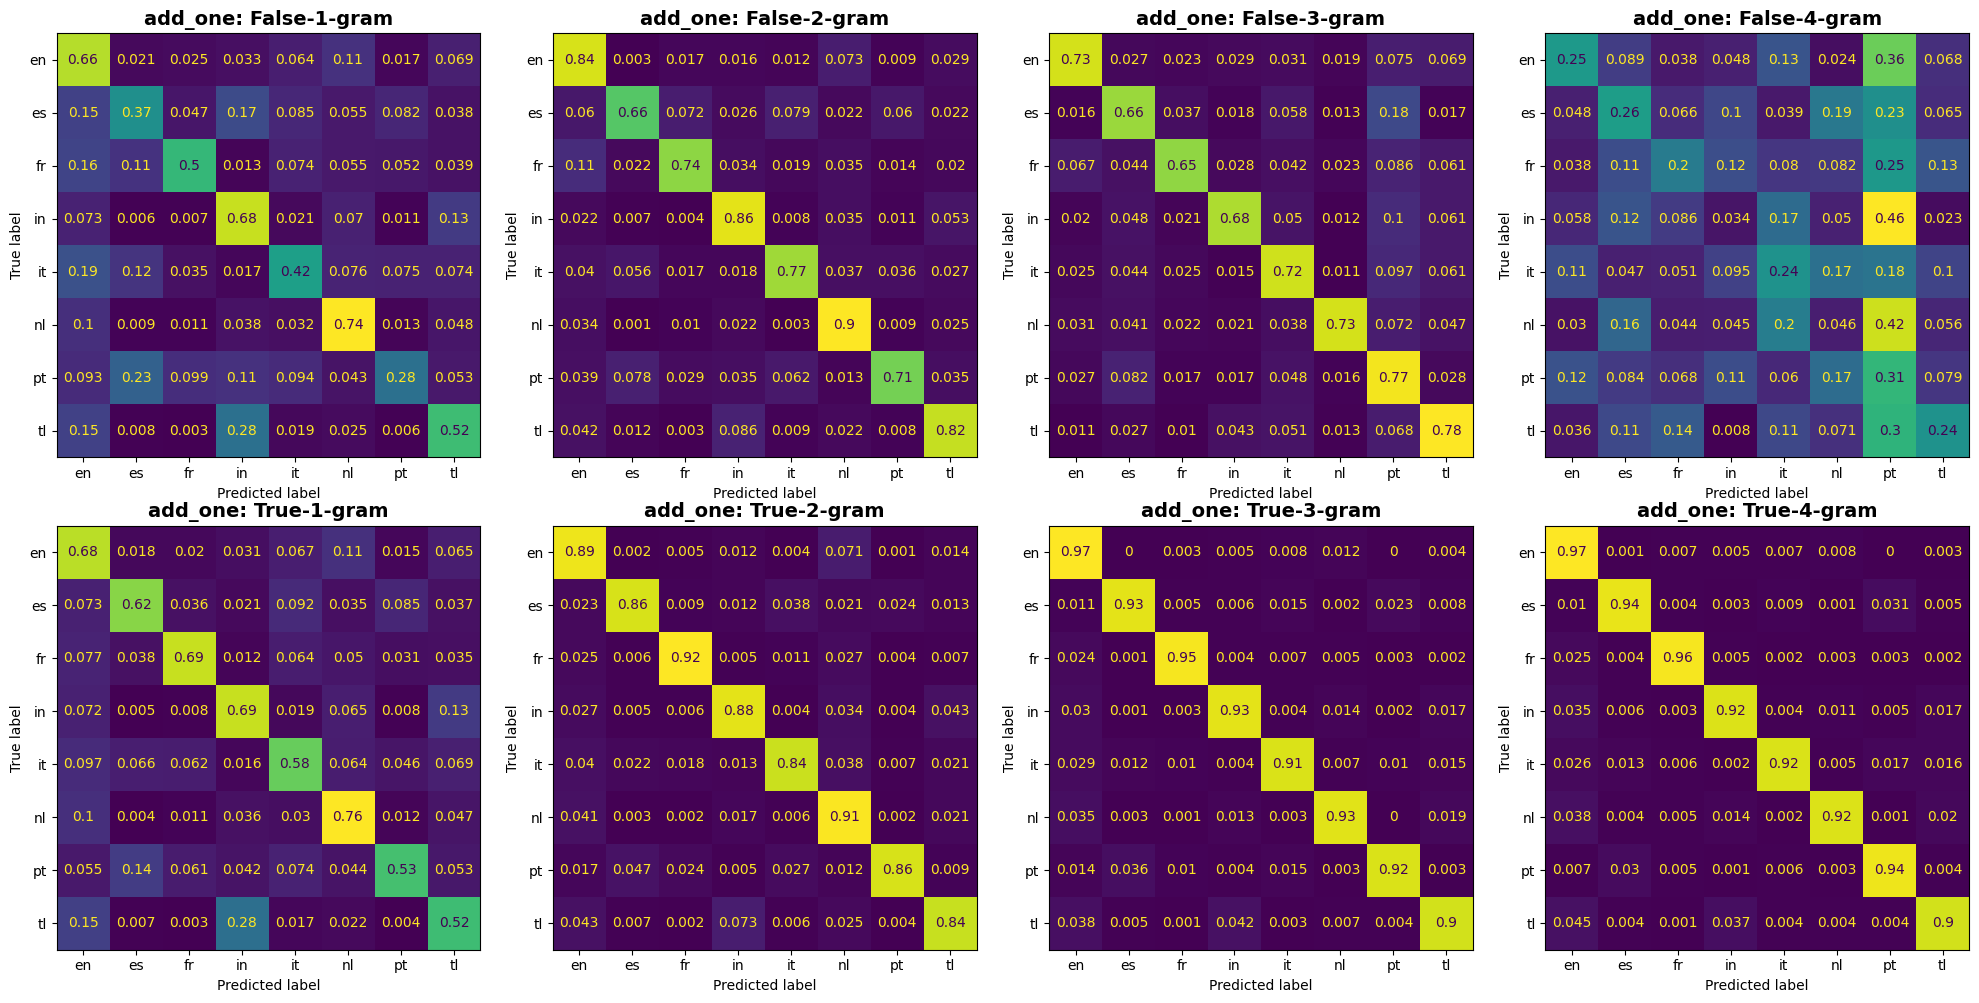

In [ ]:
columns_num = int(len(models.keys())/2)
fig, axes = plt.subplots(2, columns_num,figsize=(20, 10))
for i, (n,add_one) in enumerate(sorted(models.keys(), key=lambda x:x[1])):
  disp =  ConfusionMatrixDisplay(confusion_matrix(clasification_result['label'], clasification_result[f'add_one: {add_one}-{n}-gram'], normalize='true'), display_labels=relevant_languages)
  if add_one:
    i -= columns_num
  disp.plot(ax=axes[int(add_one)][i], colorbar=False)
  disp.ax_.set_title(f'add_one: {add_one}-{n}-gram', size=14, fontweight="bold")
plt.tight_layout()
plt.show();


<br><br><br><br>
**Part 8**
Let's use your Language model (dictionary) for generation (NLG).

When it comes to sampling from a language model decoder during text generation, there are several different methods that can be used to control the randomness and diversity of the generated text.

Some of the most commonly used methods include:

> `Greedy sampling`
In this method, the model simply selects the word with the highest probability as the next word at each time step. This method can produce fluent text, but it can also lead to repetitive or predictable output.

> `Temperature scaling`
Temperature scaling involves scaling the logits output of the language model by a temperature parameter before softmax normalization. This has the effect of smoothing the distribution of probabilities and increasing the probability of lower-probability words, which can lead to more diverse and creative output.

> `Top-K sampling`
In this method, the model restricts the sampling to the top-K most likely words at each time step, where K is a predefined hyperparameter. This can generate more diverse output than greedy sampling, while limiting the number of low-probability words that are sampled.

> `Nucleus sampling` (also known as top-p sampling)
This method restricts the sampling to the smallest possible set of words whose cumulative probability exceeds a certain threshold, defined by a hyperparameter p. Like top-K sampling, this can generate more diverse output than greedy sampling, while avoiding sampling extremely low probability words.

> `Beam search`
Beam search involves maintaining a fixed number k of candidate output sequences at each time step, and then selecting the k most likely sequences based on their probabilities. This can improve the fluency and coherence of the output, but may not produce as much diversity as sampling methods.

The choice of sampling method depends on the specific application and desired balance between fluency, diversity, and randomness. Hyperparameters such as temperature, K, p, and beam size can also be tuned to adjust the behavior of the language model during sampling.


You may read more about this concept in <a href='https://huggingface.co/blog/how-to-generate#:~:text=pad_token_id%3Dtokenizer.eos_token_id)-,Greedy%20Search,-Greedy%20search%20simply'>this</a> blog post.


**Please add the needed code for each sampeling method:**

In [ ]:
def normalize_probs(probabilities: dict[str, float]):
    s = sum(probabilities.values())
    return {k: v/s for k,v in probabilities.items()}

In [ ]:
def sample_greedy(probabilities: dict[str, float], k=1):
  return max(probabilities, key=probabilities.get)


def sample_temperature(probabilities: dict[str, float], temperature=1.0, k=1):
  vals = np.array(list(probabilities.values()))

  s = np.sum(np.e**(vals / temperature))
  new_probs = {k: np.e**(v/temperature)/s for k,v in probabilities.items()}
  pred = random.choices(list(new_probs.keys()), new_probs.values())[0]

  return pred


def sample_topK(probabilities: dict[str, float], k=1):

  k_probs = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True)[:k])
  k_probs = normalize_probs(k_probs)
  pred = random.choices(list(k_probs.keys()), k_probs.values())[0]

  return pred


def sample_topP(probabilities: dict[str, float], p=0.9):
  probabilities = normalize_probs(probabilities)
  probabilities = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))
  p_probs, total_p = {}, 0
  for prob in probabilities:
    p_probs[prob] = probabilities[prob]
    total_p += p_probs[prob]
    if total_p >= p:
      break
  pred = random.choices(list(p_probs.keys()), p_probs.values())[0]

  return pred


def sample_beam(model: dict[str, dict], local_vocabulary: list, start_tokens:list, stop_token: str, gen_length: int, n:int ,k:int):
    sequences = [[start_tokens, 0.0]]
    for i in range(gen_length):
        all_candidates = []
        for seq, score in sequences:
            if ''.join(seq[-len(stop_token):]) == stop_token or seq[-1] == END_TOKEN:
                all_candidates.append([seq, score])
                continue
            probabilities = model[''.join(seq[-n+1:])]
            if len(probabilities) == 0:
                probabilities = {random.choice(local_vocabulary): 1/local_vocabulary}
            for token, prob in probabilities.items():
                candidate = [seq + [token], score - np.log(prob)]
                all_candidates.append(candidate)
        sequences = sorted(all_candidates, key=lambda tup:tup[1])[:k]

    return sequences[0][0]

In [ ]:
methods = {
    'greedy':sample_greedy,'beam':sample_beam,'temperature':sample_temperature,'topK':sample_topK,'topP':sample_topP
};

Use your Language Model to generate each one out of the following examples with the coresponding params.
Notice the 4 core issues:
- Starting tokens
- Length of the generation
- Sampling methond (use all)
- Stop Token (if this token is sampled, stop generating)

In [ ]:
test_ = {
    'example1' : {
        'start_tokens' : "H",
        'sampling_method' : ['greedy','beam'],
        'gen_length' : "10",
        'stop_token' : "\n",
        'generation' : []
    },
    'example2' : {
        'start_tokens' : "H",
        'sampling_method' : ['temperature','topK','topP'],
        'gen_length' : "10",
        'stop_token' : "\n",
        'generation' : []
    },
    'example3' : {
        'start_tokens' : "He",
        'sampling_method' : ['greedy','beam','temperature','topK','topP'],
        'gen_length' : "20",
        'stop_token' : "me",
        'generation' : []
    }
}

In [ ]:
def generate_text(model: dict[str, dict], local_vocabulary: list, example: dict, n):
    gen_length = int(example['gen_length'])
    sampling_methods = example['sampling_method']
    start_tokens = list(example['start_tokens'])
    stop_token = example['stop_token']
    if len(start_tokens) < n-1:
        start_tokens = (n-1-len(start_tokens)) * [START_TOKEN] + start_tokens

    for method in sampling_methods:
        if method == "beam":
          text = sample_beam(model, local_vocabulary, start_tokens, stop_token, gen_length, n, k=3)
          example['generation'].append(''.join(text[n-1:]))
          continue
        text = start_tokens.copy()
        for i in range(gen_length):
            probabilities = model[''.join(text[-n+1:])]
            if len(probabilities) == 0:
                next_char = random.choice(local_vocabulary)
            else:
                next_char = methods[method](probabilities)
            text.append(next_char)
            if ''.join(text[-len(stop_token):]) == stop_token or text[-1] == END_TOKEN:
                break
        example['generation'].append(''.join(text[n-1:]))


In [ ]:
n=4
local_vocabulary = list({j for i in models[(n,True)]['en'].values() for j in i})
for example in test_.values():
    generate_text(models[(n,True)]['en'],local_vocabulary, example, n=4)

Use your LM to generate a string based on the parametes of each examples, and store the generation sequance at the generation list.

In [ ]:
### do not change ###
print('-------- NLG --------')

for k,v in test_.items():
  l = ''.join([f'\t{sm} >> {v["start_tokens"]}{g}\n' for sm,g in zip(v['sampling_method'],v['generation'])])
  print(f'{k}:')
  print(l)

-------- NLG --------
example1:
	greedy >> Hell the so
	beam >> How this th

example2:
	temperature >> Hwzijk😀laay
	topK >> Hell the so
	topP >> HowToAlled 

example3:
	greedy >> Hell the so much 24th 
	beam >> Hell this this this th
	temperature >> Heh zeppro flèche. ☺️☀
	topK >> Hell the so much 24th 
	topP >> HesQ<END>



<br><br><br>
# **Good luck!**